# Predicting Machine failures

20-02-2026. 

## Libraries

In [153]:
import numpy as np #for arrays and mathematical functions
import matplotlib.pyplot as plt #for data visualization
import seaborn as sns #complement to matplotlib
import pandas as pd #data structure and manipulation.
from sklearn.model_selection import train_test_split #for ML
from sklearn.compose import ColumnTransformer #to encode process
from sklearn.preprocessing import OneHotEncoder #to encode process
from sklearn.preprocessing import MinMaxScaler #to normalize wirth min-max method
from sklearn.linear_model import LinearRegression #to implement OLS
import datetime as dt
from sklearn.metrics import mean_absolute_error, r2_score #model eval

## 1. Data import

In [47]:
# 1. Data import
telemetry= pd.read_csv('./machine failures/PdM_telemetry.csv')

telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [222]:
machines= pd.read_csv('./machine failures/PdM_machines.csv')

machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [173]:
failures= pd.read_csv('./machine failures/PdM_failures.csv')

failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


## 2. Data Exploration

In [198]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [193]:
fail_df=failures.groupby(['failure'])['failure'].count()
fail_df

failure
comp1    192
comp2    259
comp3    131
comp4    179
Name: failure, dtype: int64

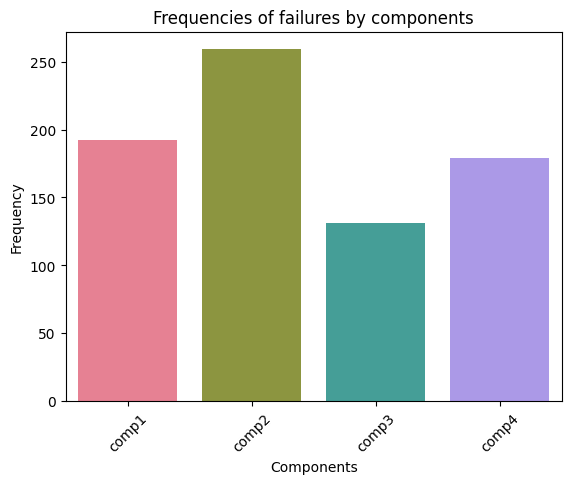

In [201]:
#chosen color palete 
pal = sns.color_palette("husl", 4) #this is a qualitative palette and we chose the first 4 colors

#plot bar x against y 
sns.barplot(x=fail_df.index, y=fail_df.values, hue=fail_df.index, palette=pal, fill=True, legend=False)#, color=colors)

#costumize the plot
plt.title("Frequencies of failures by components")
plt.xlabel("Components")
plt.ylabel("Frequency")
plt.xticks(rotation=45) # Rotate x axis names for better readability

#display the plot
plt.show()

## 3. Data Preprocess

In [78]:
#we assignf the value 1 to every failure to avoid a string issue when doing the regression
failures["failure"]=1
failures.info()

<class 'pandas.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   datetime   761 non-null    str  
 1   machineID  761 non-null    int64
 2   failure    761 non-null    int64
dtypes: int64(2), str(1)
memory usage: 18.0 KB


Now we do a *left join* using merge function from pandas, we join by the variables datetime and machineID

In [160]:
df = pd.merge(telemetry, failures, how="left", on=['datetime', 'machineID'])
df.info() 

In [161]:
'''As not every entry on telemetry has a failure we obtained a df with many NaN, 
we fill those NaN with 0'''

df["failure"]=df["failure"].fillna(0)

In [162]:
# check the na replace
df.info() 

<class 'pandas.DataFrame'>
RangeIndex: 876142 entries, 0 to 876141
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876142 non-null  str    
 1   machineID  876142 non-null  int64  
 2   volt       876142 non-null  float64
 3   rotate     876142 non-null  float64
 4   pressure   876142 non-null  float64
 5   vibration  876142 non-null  float64
 6   failure    876142 non-null  float64
dtypes: float64(5), int64(1), str(1)
memory usage: 46.8 MB


### Slicing

In [137]:
# slice
# X (independent variables) are all the features BUT datetime and the failure variable
X = df.drop(["failure", "datetime"], axis=1) #we drop price from the df
X

# dependent variable
y=df['failure']

In [163]:
X.head()

,machineID,volt,rotate,pressure,vibration
0,1,176.217853,418.504078,113.077935,45.087686
1,1,162.879223,402.747490,95.460525,43.413973
2,1,170.989902,527.349825,75.237905,34.178847
3,1,162.462833,346.149335,109.248561,41.122144
4,1,157.610021,435.376873,111.886648,25.990511


In [164]:
y[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: failure, dtype: float64

## 4. Training the model

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#to see the dimension of the 4 sets created
[a.shape for a in (X_train, X_test, y_train, y_test)]

[(700913, 5), (175229, 5), (700913,), (175229,)]

In [140]:
# We define our model as linear regresion (OLS)
model = LinearRegression()

# we train our model using the training samples
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


## 5. Making predictions

In [214]:
# we make a prediction of y based on our model and training sample
y_train_hat = model.predict(X_train)
print(f"The first five predicted values are: {y_train_hat[:5]}")
print(f"While the first actual values on the training sample are: {y_train.values[:5]}")

The first five predicted values are: [0.00046893 0.00104997 0.00117647 0.00272323 0.00097299]
While the first actual values on the training sample are: [0. 0. 0. 0. 0.]


In [217]:
#again we make a predicion, but now based on the independent variables of the test sample
y_test_hat = model.predict(X_test)
print(f"The first five predicted values are: {y_test_hat[:5]}")
print(f"While the first actual values on the test sample are: {y_test.values[:5]}")

The first five predicted values are: [0.00020772 0.00188463 0.00020203 0.00192498 0.00303337]
While the first actual values on the test sample are: [0. 0. 0. 0. 0.]


## 6. Evaluation

In [218]:
# ---------------- EVAL

# we evaluate the model-fit in relation to our testing sample
# calculate MEA score
test_mae = mean_absolute_error(y_test, y_test_hat)

# calculate R2 score
test_r2 = r2_score(y_test, y_test_hat)

print(f"Mean absolute error (testing sample)  = {test_mae}.")
print(f"r-squared score  (testing sample) = {test_r2}.")
print("NOTE: Remember that in the case of R^2 the higher the better")

Mean absolute error (testing sample)  = 0.0017910400126265999.
r-squared score  (testing sample) = 0.0007058318580563938.
NOTE: Remember that in the case of R^2 the higher the better


## A Diferent approach...

In [ ]:
time series 